In [17]:
# Import the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

# later you can try to 

Using Dropout https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success Data.

In [18]:
# Load the datasets
df = pd.read_csv("dropoutData.csv")
df.shape


(3630, 35)

In [3]:
train_ratio = 0.7


# split whole into train and test, then split test into val and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', axis=1), df['Target'], train_size=train_ratio, random_state=123)



In [4]:
val_ratio = 0.15
test_ratio = 0.15

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=val_ratio/(val_ratio + test_ratio), random_state=123)
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
n = n_train + n_val + n_test
print(f'No. of train samples: {X_train.shape} \n')
print(f'No. of val samples: {X_val.shape} \n')
print(f'No. of test samples: {X_test.shape} \n')
print(f'No. of train samples: {y_train.shape} \n')
print(f'No. of val samples: {y_val.shape} \n')
print(f'No. of test samples: {y_test.shape} \n')
print(f'Train test val ratio: {n_train/n}, {n_test/n}, {n_val/n}')

No. of train samples: (2541, 34) 

No. of val samples: (544, 34) 

No. of test samples: (545, 34) 

No. of train samples: (2541,) 

No. of val samples: (544,) 

No. of test samples: (545,) 

Train test val ratio: 0.7, 0.15013774104683195, 0.14986225895316804


In [5]:
# converting dataframe to numpy array because pytorch takes numpy arrays (or torch.tensor) as input.
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
X_val=X_val.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_val=y_val.to_numpy()
type(X_train)
print(f'No. of train samples: {X_train.shape} \n')
print(f'No. of val samples: {X_val.shape} \n')
print(f'No. of test samples: {X_test.shape} \n')
print(f'No. of train samples: {y_train.shape} \n')
print(f'No. of val samples: {y_val.shape} \n')
print(f'No. of test samples: {y_test.shape} \n')

No. of train samples: (2541, 34) 

No. of val samples: (544, 34) 

No. of test samples: (545, 34) 

No. of train samples: (2541,) 

No. of val samples: (544,) 

No. of test samples: (545,) 



In [6]:
from torch.utils.data import DataLoader, TensorDataset
import torch

In [7]:
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).long())
val_dataset= TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).long())
test_dataset=TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).long())


In [16]:
torch.tensor?

Docstring:
tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor

Constructs a tensor with no autograd history (also known as a "leaf tensor", see :doc:`/notes/autograd`) by copying :attr:`data`.

.. warning::

    When working with tensors prefer using :func:`torch.Tensor.clone`,
    :func:`torch.Tensor.detach`, and :func:`torch.Tensor.requires_grad_` for
    readability. Letting `t` be a tensor, ``torch.tensor(t)`` is equivalent to
    ``t.clone().detach()``, and ``torch.tensor(t, requires_grad=True)``
    is equivalent to ``t.clone().detach().requires_grad_(True)``.

.. seealso::

    :func:`torch.as_tensor` preserves autograd history and avoids copies where possible.
    :func:`torch.from_numpy` creates a tensor that shares storage with a NumPy array.

Args:
    data (array_like): Initial data for the tensor. Can be a list, tuple,
        NumPy ``ndarray``, scalar, and other types.

Keyword args:
    dtype (:class:`torch.dtype`, optional): the de

In [8]:
## Dataloader

train_bs = 32
val_bs = 32
test_bs = 32

# batch size in the power of 2, up to 2^6
# left ouvers are eather drop_last TRUE or NOT
# shuffle to ensure less bias , does not matter in validation or test 
train_dataloader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True, drop_last=True) #dataset   
val_dataloader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_bs, shuffle=False, drop_last=True)

# train_dataloader

print(f'No. of batches train dataloader: {len(train_dataloader)} and total train samples: {len(train_dataloader)*train_bs}, {train_dataloader.batch_size}')
print(f'No. of batches val dataloader: {len(val_dataloader)} and total val samples: {len(val_dataloader)*val_bs}')
print(f'No. of batches test dataloader: {len(test_dataloader)} and test train samples: {len(test_dataloader)*test_bs}')
# X = next(iter(train_dataloader))

# (X,y) = next(iter(train_dataloader))

No. of batches train dataloader: 79 and total train samples: 2528, 32
No. of batches val dataloader: 17 and total val samples: 544
No. of batches test dataloader: 17 and test train samples: 544


In [ ]:
# print(X[1])

In [9]:
# Train and evaluate functions for training and validating the model

def train_loop(model, tr_dataloader, loss_fn, opt):
    avg_loss = 0 # to store running loss
    model.train() # Set model in training mode
    for batch_idx, (X, y) in enumerate(tr_dataloader):
        pred = model(X) # make prediction on current batch
        loss = loss_fn(pred,y) # calculate loss
        loss.backward() # calculates gradients
        opt.step() # update weights
        opt.zero_grad() # set gradients to zero for next batch,  not for transformers but only for 
        avg_loss += loss.item()
        #print(f'Batch no. {batch_idx}, Batch loss: {loss.item():.5f}')
    print(f'Average training Loss: {avg_loss/len(tr_dataloader):.5f}')
    train_loss = avg_loss/len(tr_dataloader)
    return train_loss

def test_loop(model, dataloader, loss_fn ):
    test_loss = 0.
    correct = 0
    model.eval()
    bs = dataloader.batch_size
    for batch_idx, (X, y) in enumerate(dataloader):
        pred = model(X) # make prediction on current batch
        test_loss += loss_fn(pred,y).item() # calculate loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item() # not required for regression

    test_loss /= len(dataloader)
    correct /= (len(dataloader)*dataloader.batch_size)
    print(f'Error: \n Accuracy: {(100*correct):0.1f}%, Avg test loss: {test_loss:.5f} \n')


    return test_loss


In [10]:
# define a model class # Model 1
from torch import nn, optim

class Network(nn.Module):
    def __init__(self,hid_layer=[100,100]):  # default number of layer
        super().__init__()
        self.net = nn.Sequential(   # seqential way forward
            nn.Linear(34, hid_layer[0]),    # 34 = number ofd features, better to insert number of 
            nn.ReLU(),
            nn.Linear(hid_layer[0],hid_layer[1]),
            nn.ReLU(),
            nn.Linear(hid_layer[1], 2),   # 2 as number of classification 
        )
    def forward(self,x):
        logits = self.net(x)
        return logits



In [11]:
## Calling model 1
hid_layer = [80,45] # number of nodes
model = Network(hid_layer) #instantiate

epochs = 20
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()    # for regression ..... nn.mse_loss 
opt = optim.Adam(model.parameters(), lr=learning_rate) #optimizer
train_loss = [] # list to store train loss
val_loss = [] # list to store val loss

for t in range(epochs):
    print(f'Epoch {t}')
    train_loss.append(train_loop(model, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss.append(test_loop(model, val_dataloader, loss_fn))



Epoch 0
Average training Loss: 0.46245
Error: 
 Accuracy: 90.8%, Avg test loss: 0.25967 

Epoch 1
Average training Loss: 0.30666
Error: 
 Accuracy: 90.6%, Avg test loss: 0.24554 

Epoch 2
Average training Loss: 0.27635
Error: 
 Accuracy: 92.5%, Avg test loss: 0.21074 

Epoch 3
Average training Loss: 0.25951
Error: 
 Accuracy: 91.7%, Avg test loss: 0.22257 

Epoch 4
Average training Loss: 0.26024
Error: 
 Accuracy: 91.5%, Avg test loss: 0.23297 

Epoch 5
Average training Loss: 0.24354
Error: 
 Accuracy: 90.8%, Avg test loss: 0.24444 

Epoch 6
Average training Loss: 0.23704
Error: 
 Accuracy: 93.0%, Avg test loss: 0.20549 

Epoch 7
Average training Loss: 0.24326
Error: 
 Accuracy: 92.1%, Avg test loss: 0.24317 

Epoch 8
Average training Loss: 0.23359
Error: 
 Accuracy: 92.8%, Avg test loss: 0.21737 

Epoch 9
Average training Loss: 0.22794
Error: 
 Accuracy: 92.6%, Avg test loss: 0.21014 

Epoch 10
Average training Loss: 0.23954
Error: 
 Accuracy: 91.7%, Avg test loss: 0.21022 

Epoch 11


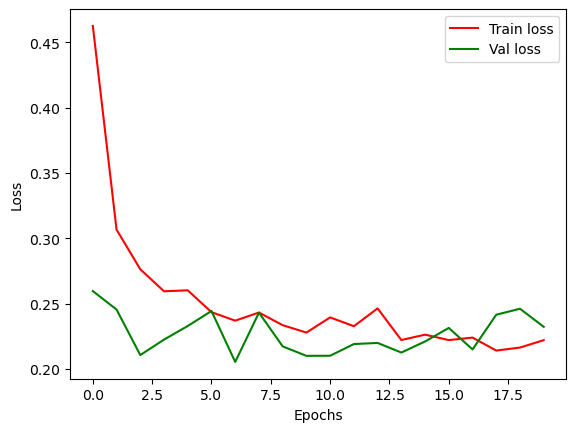

In [12]:

from matplotlib import pyplot as plt
xax = range(epochs)
plt.plot(xax, np.array(train_loss),'r-', xax, np.array(val_loss),'g-'  )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Val loss' ])
plt.show()

In [13]:
print('Performing test...\n')
test_loop(model,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 88.2%, Avg test loss: 0.34083 



0.34082718719454375

In [21]:
# define a model class # Model 2
from torch import nn, optim

class Network2(nn.Module):
    def __init__(self,hid_layer=[100]):  # default number of layer
        super().__init__()
        self.net = nn.Sequential(   # seqential way forward
            nn.Linear(34, hid_layer[0]),    # 34 = number ofd features, better to insert number of 
            nn.ReLU(),
            nn.Linear(hid_layer[0], 2),   # 2 as number of classification 
        )
    def forward(self,x):
        logits = self.net(x)
        return logits


In [31]:
## Calling model 1

model = Network2(hid_layer) #instantiate
hid_layer = [80] # number of nodes
epochs = 20
learning_rate = 1e-2
loss_fn = nn.CrossEntropyLoss()    # for regression ..... nn.mse_loss 
opt = optim.Adam(model.parameters(), lr=learning_rate) #optimizer
train_loss2 = [] # list to store train loss
val_loss2 = [] # list to store val loss

for t in range(epochs):
    train_loss2.append(train_loop(model, train_dataloader,  loss_fn, opt)) # to plot the graph
    val_loss2.append(test_loop(model, val_dataloader, loss_fn))
test_loop(model,test_dataloader,loss_fn)

Average training Loss: 0.45493
Error: 
 Accuracy: 91.9%, Avg test loss: 0.23490 

Average training Loss: 0.27421
Error: 
 Accuracy: 92.1%, Avg test loss: 0.20881 

Average training Loss: 0.27527
Error: 
 Accuracy: 90.1%, Avg test loss: 0.22811 

Average training Loss: 0.25088
Error: 
 Accuracy: 91.9%, Avg test loss: 0.21195 

Average training Loss: 0.26476
Error: 
 Accuracy: 91.7%, Avg test loss: 0.22119 

Average training Loss: 0.25529
Error: 
 Accuracy: 90.8%, Avg test loss: 0.22797 

Average training Loss: 0.24480
Error: 
 Accuracy: 91.9%, Avg test loss: 0.22142 

Average training Loss: 0.27116
Error: 
 Accuracy: 91.9%, Avg test loss: 0.23643 

Average training Loss: 0.23838
Error: 
 Accuracy: 93.0%, Avg test loss: 0.20498 

Average training Loss: 0.23261
Error: 
 Accuracy: 92.5%, Avg test loss: 0.21412 

Average training Loss: 0.23449
Error: 
 Accuracy: 91.9%, Avg test loss: 0.22888 

Average training Loss: 0.23361
Error: 
 Accuracy: 92.3%, Avg test loss: 0.22230 

Average training

0.33350030201322894

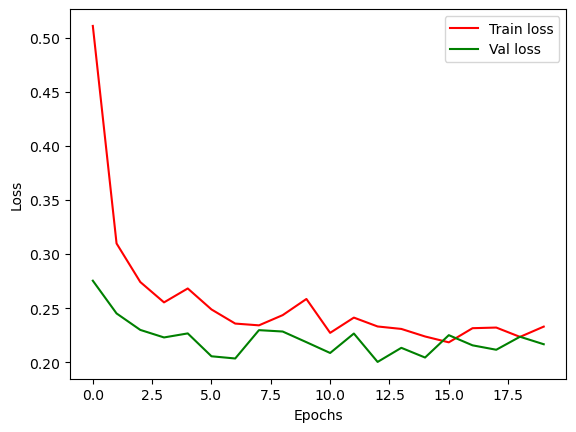

In [28]:
from matplotlib import pyplot as plt
xax = range(epochs)
plt.plot(xax, np.array(train_loss2),'r-', xax, np.array(val_loss2),'g-'  )
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Val loss' ])
plt.show()

In [29]:
print('Performing test...\n')
test_loop(model,test_dataloader,loss_fn)

Performing test...

Error: 
 Accuracy: 88.1%, Avg test loss: 0.32953 



0.3295343264060862

In [32]:
train_loss2

[0.45492724866806705,
 0.27420517226940466,
 0.2752709585843207,
 0.2508757873143576,
 0.26476469452056706,
 0.25529012437674065,
 0.24480487552436092,
 0.2711598112990585,
 0.23837956154271017,
 0.23261363346931302,
 0.2344921391598786,
 0.23361067832270754,
 0.22956936325453506,
 0.22314743428856512,
 0.22874747301581538,
 0.22949410060161277,
 0.2325472697804246,
 0.23049792076779319,
 0.22919225353228895,
 0.228192028884269]

In [43]:
hid_layers = [[30], [60], [80], [100]] # number of nodes
all_epochs = [10, 15, 20]
learning_rates = [1e-2, 1e-3, 1e-4]

results = pd.DataFrame(columns=['hid_layer', 'epochs', 'learning_rate','test_loss'])

for hid_layer in hid_layers:
    for epochs in all_epochs:
        for learning_rate in learning_rates: 
            model = Network2(hid_layer) # instantiate
            loss_fn = nn.CrossEntropyLoss()    # for classification
            opt = optim.Adam(model.parameters(), lr=learning_rate) #optimizer
            test_loss = test_loop(model, test_dataloader, loss_fn)
            model_info = {
                'hid_layer': hid_layer,
                'epochs': epochs,
                'learning_rate': learning_rate,
                'test_loss': test_loss 
            }
            results = pd.concat([results, pd.DataFrame(model_info)], ignore_index=True)



Error: 
 Accuracy: 60.3%, Avg test loss: 0.88023 

Error: 
 Accuracy: 40.3%, Avg test loss: 1.34565 

Error: 
 Accuracy: 63.2%, Avg test loss: 0.93628 

Error: 
 Accuracy: 35.7%, Avg test loss: 1.09517 

Error: 
 Accuracy: 35.8%, Avg test loss: 1.83442 

Error: 
 Accuracy: 47.4%, Avg test loss: 1.00902 

Error: 
 Accuracy: 41.7%, Avg test loss: 0.86711 

Error: 
 Accuracy: 37.9%, Avg test loss: 1.25465 

Error: 
 Accuracy: 28.5%, Avg test loss: 1.54511 

Error: 
 Accuracy: 60.1%, Avg test loss: 0.77798 

Error: 
 Accuracy: 62.5%, Avg test loss: 1.66250 

Error: 
 Accuracy: 66.5%, Avg test loss: 0.66790 

Error: 
 Accuracy: 62.5%, Avg test loss: 1.77743 

Error: 
 Accuracy: 34.4%, Avg test loss: 0.90257 

Error: 
 Accuracy: 39.3%, Avg test loss: 1.20038 

Error: 
 Accuracy: 62.7%, Avg test loss: 0.95142 

Error: 
 Accuracy: 64.7%, Avg test loss: 0.63649 

Error: 
 Accuracy: 53.3%, Avg test loss: 0.93813 

Error: 
 Accuracy: 46.7%, Avg test loss: 0.80011 

Error: 
 Accuracy: 37.3%, Avg t

/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_70667/1566833845.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame(model_info)], ignore_index=True)


In [44]:
results

,hid_layer,epochs,learning_rate,test_loss
0,30,10,0.0100,0.880228
1,30,10,0.0010,1.345648
2,30,10,0.0001,0.936279
3,30,15,0.0100,1.095173
4,30,15,0.0010,1.834418
5,30,15,0.0001,1.009022
6,30,20,0.0100,0.867110
7,30,20,0.0010,1.254653
8,30,20,0.0001,1.545110
9,60,10,0.0100,0.777979


In [45]:
test_loop(model, test_dataloader, loss_fn)

Error: 
 Accuracy: 62.3%, Avg test loss: 0.86744 



0.867435592062333